In [1]:
#import tarfile
#tf = tarfile.open("fcp_package.tar.gz")
#tf.extractall()

# 1. Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import re
from datetime import datetime

# nlp pipeline
import spacy

# text analysis
import gensim
from gensim.models import LdaModel, ldamodel
from gensim.models import LsiModel, lsimodel
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
import pyLDAvis
import pyLDAvis.gensim 

# visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 2. Options for data vizualisation on screen and Package version

In [3]:
# data vis
%matplotlib inline

# send output to the screen
LINE = ''.join(['\n', 79 * '~', '\n'])

# coding style
print('Coding style as per PEP8', '', end=LINE)

print("""
spaCy version: {}
Gensim version: {}
""".format(spacy.__version__, gensim.__version__))

Coding style as per PEP8 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

spaCy version: 2.2.4
Gensim version: 3.8.3



# 3. Reading the data

In [4]:
# Reading the business level data first
folder = 'brexit'
File0 = 'pr__sus_docs.csv'
File1 = 'pr__sus_attr.csv'
File2 = 'pr__sources.csv'
pr_docs = pd.read_csv(os.path.join(folder,File0))
pr_attr = pd.read_csv(os.path.join(folder,File1))
pr_source = pd.read_csv(os.path.join(folder,File2))

In [5]:
pr_attr.head()

,article,source,variable,value
0,0,0,date,2016-05-04 00:00:00
1,0,0,byline,Anna Murphy
2,0,0,section,"T2;FEATURES; Pg. 6,7"
3,0,0,length,1452
4,1,0,date,2016-05-13 00:00:00


# 4. Cleaning of data

In [6]:
#Transposing the source data and dropping first row
#pr_source = pr_source.T
#pr_source.drop(pr_source.index[0], inplace=True)

# Adding a source column to source data
#pr_source.insert(0, 'source', range(0, 0 + len(pr_source)))

# Renaming the columns
#pr_source.columns.values[1] = 'newspaper'

# Merging the source and docs data
#df = pd.merge(pr_source, pr_docs, on='source', how='right')

# Dropping source column
#df.drop(['source'], axis=1, inplace=True)
#df.rename(columns={'newspaper': 'source'}, inplace=True)
# --+ reorganize cols
#df = df[['id', 'source', 'text', 'article', 'start', 'sort']]

In [7]:
# slice the attriute data to get the date
pr_date = pr_attr[pr_attr.variable == 'date'].drop(['variable','source'], axis=1)

# Brexit referendum expected timespan is 23/04/2016 to 23/08/2016
pr_time = pr_date[(pr_date.value < '2016-08-24 00:00:00') & (pr_date.value >= '2016-04-23 00:00:00')]

# get list of chosen article id
articles = pr_time.article.to_list()

# join pr_docs and pr_timespan
df = pd.merge(pr_time, pr_docs, on=['article', 'article']).rename(columns={'value':'date'})
df.sort_values('date', inplace=True)

df['date'] = pd.to_datetime(df['date'], utc = True).dt.date

# Merging the text corpora data with attribute date
#df = pd.merge(df, pr_attr,on='article', how='left')

# Dropping redundat columns and renaming source_x
df.drop(['start','id','source','article','sort'],axis=1, inplace=True)
#df.rename(columns={'source_x':'source', 'value':'date'}, inplace=True)

In [8]:
df.head()

,date,text
445,2016-04-23,HIGHLIGHT: Ed Crooks is fascinated by a biogra...
444,2016-04-23,HIGHLIGHT: \'If China could be persuaded to co...
443,2016-04-23,"After months of wrangling, eurozone finance mi..."
442,2016-04-23,How can the world best combat global warming? ...
446,2016-04-26,"Zaoui & Co, the tiny European advisory firm se..."


In [9]:
# Seggregating the data to post brexit referendum period and pre brexit period depending upon the date
# Brexit referendum date is june 23,2016 or 2016-06-23

# Set the Index to be the Date
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
df.set_index('date', inplace=True)

# Sort the Data
df = df.sort_values('date')

# Slice the Data to get pre brexit referendum data
To   = '2016-06-22'
df_pre = df.loc[:To,:]

In [10]:
# Slicing the data to find post brexit data
From   = '2016-06-23'
df_post = df.loc[From:,:]

# Understanding prebrexit topics

# 5. NLP pipeline

In [11]:
# docs as list and conversion to lower case
def cleaning(_string):
    # purge non alpha characters
    alpha = re.sub("[^A-Za-z']+", ' ', str(_string))
    return alpha.lower()
                  
# clean text
docs_pre = [cleaning(item) for item in df_pre.text.values]

# hyphen to underscores
docs_pre = [re.sub(r'\b-\b', '_', text) for text in docs_pre]

# underscores to space
docs_pre = [re.sub(r'\b_\b', ' ', text) for text in docs_pre]

In [12]:
# load pipeline
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser', 'tagger'])

In [13]:
# expand on spaCy's stopwords
# my stopwrods
my_stopwords = ['\x1c',
                'ft', 'wsj', 'time', 'sec','year',
                'say', 'says', 'said','highlight',
                'mr.', 'mister', 'mr', 'miss', 'ms',
                'inc']
# expand on spacy's stopwords
for stopword in my_stopwords:
    nlp.vocab[stopword].is_stop = True

# 6. Tokenize text

In [14]:
# tokenized text
docs_tokens_pre = []

for doc in docs_pre:
    tmp_tokens = [token.lemma_ for token in nlp(doc) 
                  if not token.is_stop
                  and not token.is_space
                  and not token.is_punct
                  and not token.is_oov
                  and len(token.lemma_) > 1
                  and not token.like_num
                  and not token.like_url
                  and not token.like_email
                  and not token.is_currency]
    docs_tokens_pre.append(tmp_tokens)
    tmp_tokens = []
    
    
# Storing the tokenized text
df_pre.loc[:, 'tkn_text'] = docs_tokens_pre

C:\Users\sachi\anaconda3\envs\SMM694NLP\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sachi\anaconda3\envs\SMM694NLP\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# 7. Taking into account bi-grams and tri-grams

In [15]:
#Getting rid of common terms
common_terms = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']
# find phrases
bigram = Phrases(docs_tokens_pre,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=common_terms)

trigram = Phrases(bigram[docs_tokens_pre],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=common_terms)

docs_phrased_pre = [trigram[bigram[line]] for line in docs_tokens_pre]

# check nlp pipeline
#print('',
      #'Published abstract:', docs[0],
      #'Tokenized abstract:', docs_tokens[0],
      #'Tri-grammed tokenised abstract:', docs_phrased[0],
     # sep=LINE, end=LINE)

In [16]:
df_pre.head()

,text,tkn_text
date,,
2016-04-23,HIGHLIGHT: Ed Crooks is fascinated by a biogra...,"[ed, crook, fascinate, biography, scientist, p..."
2016-04-23,HIGHLIGHT: \'If China could be persuaded to co...,"[china, persuade, construct, energy, efficient..."
2016-04-23,"After months of wrangling, eurozone finance mi...","[month, wrangle, eurozone, finance, minister, ..."
2016-04-23,How can the world best combat global warming? ...,"[world, well, combat, global, warm, people, ta..."
2016-04-26,"Zaoui & Co, the tiny European advisory firm se...","[co, tiny, european, advisory, firm, set, brot..."


# 8. Topic Modelling

# 8.1 Training the model

In [17]:
# create dictionary and text corpus
dict_pre = Dictionary(docs_phrased_pre)
corpus_pre = [dict_pre.doc2bow(doc) for doc in docs_phrased_pre]

# 8.2 Implementation of LDA algorithm

In [18]:
# Build LDA model with n_topics 20
n_topics = 20
lda_model_pre = gensim.models.ldamodel.LdaModel(corpus=corpus_pre,
                                           id2word=dict_pre,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics

In [19]:
# Print the Keywors
print(lda_model_pre.print_topics())
doc_lda_pre = lda_model_pre[corpus_pre]

[(0, '0.014*"development" + 0.012*"government" + 0.012*"business" + 0.012*"country" + 0.012*"work" + 0.008*"global" + 0.007*"sustainable" + 0.007*"international" + 0.007*"world" + 0.007*"sector"'), (1, '0.017*"company" + 0.017*"energy" + 0.016*"uk" + 0.015*"cent" + 0.012*"market" + 0.012*"be" + 0.011*"fund" + 0.010*"price" + 0.010*"investor" + 0.010*"xc"'), (2, '0.052*"car" + 0.034*"emission" + 0.033*"electric" + 0.027*"vehicle" + 0.023*"transport" + 0.019*"battery" + 0.018*"charge" + 0.013*"road" + 0.011*"fleet" + 0.010*"taxi"'), (3, '0.042*"font" + 0.037*"austin_news_deck_web" + 0.031*"uk_asset_font" + 0.031*"url_http_eip_telegraph" + 0.030*"co" + 0.027*"format" + 0.026*"px" + 0.021*"woff" + 0.021*"italic" + 0.020*"medium"'), (4, '0.018*"impact" + 0.013*"company" + 0.013*"investment" + 0.012*"invest" + 0.011*"product" + 0.009*"consumer" + 0.008*"brand" + 0.007*"group" + 0.007*"world" + 0.006*"sustainability"'), (5, '0.019*"prince" + 0.019*"palace" + 0.017*"duke" + 0.017*"london" + 0.

# Model Evaluation

In [20]:
# The range of coherence values as the number of retained topics change
# define function
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_pre,
                                               id2word=dict_pre,
                                               num_topics=n_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100)
                                               #passes=10,
                                               #alpha='auto',
                                               #per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# collect coherence scores as the number of retained topics change
limit,start,step = 20, 1, 1
model_list, coher_vals = compute_coherence_values(dictionary=dict_pre,
                                                  corpus=corpus_pre,
                                                  texts=docs_phrased_pre,
                                                  start=start,
                                                  limit=limit,
                                                  step=step)

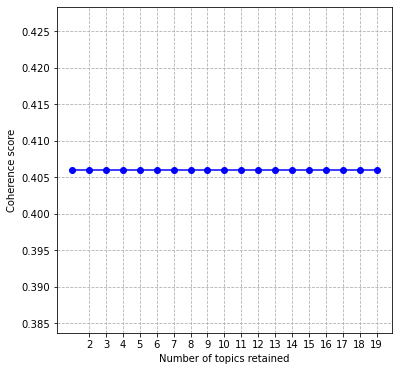

In [22]:
# Coherence scores plot
# data series
x = range(start, limit, step)
y = coher_vals

# create figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

# plot data
ax.plot(x,y, marker='o', color='b', ls='-')

# axes
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(np.arange(2, 20, 1))

# reference line
#ax.axvline(x=11, ymin=0, ymax=1, color='r')

# grid
ax.grid(True, ls='--')

# save plot to file
folder = 'exhibits'
file = 'pre_1.pdf'
plt.savefig(os.path.join(folder,file),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

plt.show()

In [23]:
coher_vals

[0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635,
 0.40603636661758635]

# Model evaluation approach 2

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_pre.log_perplexity(corpus_pre))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_pre, texts=docs_phrased_pre, dictionary=dict_pre, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.36601192368809

Coherence Score:  0.47243474228014737


In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus_pre, num_topics=num_topics, id2word=dict_pre)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=docs_phrased_pre, dictionary=dict_pre, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

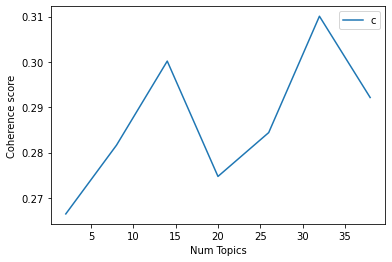

In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_pre, corpus=corpus_pre, texts=docs_phrased_pre, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# save plot to file
folder = 'exhibits'
file = 'pre_2.pdf'
plt.savefig(os.path.join(folder,file),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2665
Num Topics = 8  has Coherence Value of 0.2816
Num Topics = 14  has Coherence Value of 0.3002
Num Topics = 20  has Coherence Value of 0.2747
Num Topics = 26  has Coherence Value of 0.2844
Num Topics = 32  has Coherence Value of 0.3101
Num Topics = 38  has Coherence Value of 0.2921


In [28]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

def format_topics_sentences(ldamodel=lda_model_pre, corpus=corpus_pre, texts=docs_pre):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus_pre]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_pre, texts=docs_pre)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

[(0, '0.012*"service" + 0.006*"professor" + 0.004*"community" + 0.004*"health" + 0.004*"xc" + 0.004*"work" + 0.003*"child" + 0.003*"government" + 0.003*"uk" + 0.003*"education"'), (1, '0.005*"need" + 0.005*"fund" + 0.004*"company" + 0.004*"new" + 0.003*"service" + 0.003*"country" + 0.003*"uk" + 0.003*"xc" + 0.003*"people" + 0.003*"year"'), (2, '0.011*"service" + 0.005*"uk" + 0.005*"company" + 0.004*"new" + 0.004*"xc" + 0.004*"country" + 0.004*"people" + 0.004*"fund" + 0.004*"business" + 0.003*"community"'), (3, '0.005*"service" + 0.005*"xc" + 0.004*"professor" + 0.004*"new" + 0.004*"uk" + 0.003*"market" + 0.003*"business" + 0.003*"work" + 0.003*"sustainability" + 0.003*"need"'), (4, '0.017*"service" + 0.006*"community" + 0.005*"people" + 0.004*"xc" + 0.004*"world" + 0.003*"education" + 0.003*"uk" + 0.003*"year" + 0.003*"director" + 0.003*"come"'), (5, '0.008*"company" + 0.006*"service" + 0.005*"people" + 0.004*"xc" + 0.004*"work" + 0.004*"business" + 0.003*"new" + 0.003*"government" + 

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.9703,"service, uk, be, country, xc, government, peop...",highlight ed crooks is fascinated by a biograp...
1,1,17.0,0.9926,"service, company, greece, people, community, n...",highlight 'if china could be persuaded to cons...
2,2,17.0,0.5466,"service, company, greece, people, community, n...",after months of wrangling eurozone finance min...
3,3,17.0,0.9387,"service, company, greece, people, community, n...",how can the world best combat global warming m...
4,4,14.0,0.9960,"service, uk, be, country, xc, government, peop...",zaoui co the tiny european advisory firm set u...
5,5,6.0,0.5768,"service, people, business, market, company, co...",sir caroline binham 's report fca sets out pla...
6,6,6.0,0.9933,"service, people, business, market, company, co...",it has been a little over a year since i began...
7,7,6.0,0.4577,"service, people, business, market, company, co...",the world 's largest government backed investm...
8,8,13.0,0.9633,"service, company, uk, xc, year, group, work, c...",if we take control we can deliver for our mari...
9,9,6.0,0.9981,"service, people, business, market, company, co...",i am a year old vicar married but as yet no ch...


In [29]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9927,"service, professor, community, health, xc, wor...",bj xc xb rn borg tennis player five times wimb...
1,1.0,0.9979,"need, fund, company, new, service, country, uk...",highlight 'torres began a quest to rescue cata...
2,2.0,0.9979,"service, uk, company, new, xc, country, people...",at last month 's world humanitarian summit ken...
3,3.0,0.9966,"service, xc, professor, new, uk, market, busin...",highlight 'radical ' solutions sought for busi...
4,4.0,0.9984,"service, community, people, xc, world, educati...",it is an evocative image that captures the raw...


In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,14.0,"service, uk, be, country, xc, government, peop...",8.0,0.0228
1.0,17.0,"service, company, greece, people, community, n...",6.0,0.0171
2.0,17.0,"service, company, greece, people, community, n...",17.0,0.0484
3.0,17.0,"service, company, greece, people, community, n...",7.0,0.0199
4.0,14.0,"service, uk, be, country, xc, government, peop...",8.0,0.0228
...,...,...,...,...
346.0,2.0,"service, uk, company, new, xc, country, people...",NaN,NaN
347.0,2.0,"service, uk, company, new, xc, country, people...",NaN,NaN
348.0,11.0,"business, service, food, work, people, new, uk...",NaN,NaN
349.0,11.0,"business, service, food, work, people, new, uk...",NaN,NaN


In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_pre, corpus_pre, dict_pre)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.225713 -0.034979       1        1  20.608707
13     0.283501 -0.029755       2        1  19.222744
0      0.302400 -0.006413       3        1  14.468959
1      0.277276 -0.116349       4        1  11.141949
14     0.248978 -0.109038       5        1  10.398607
4      0.224601 -0.088363       6        1   7.025876
9      0.096010  0.335867       7        1   6.158617
8      0.080609  0.325567       8        1   5.597865
3     -0.137730 -0.017791       9        1   1.113657
11    -0.128368 -0.038960      10        1   0.763228
12    -0.155780  0.005721      11        1   0.762068
6     -0.119892 -0.046892      12        1   0.678882
2     -0.140860 -0.026176      13        1   0.621844
5     -0.137969  0.001555      14        1   0.555509
18    -0.162072 -0.007353      15        1   0.545952
10    -0.157672 -0.029580      16        1   0.261818
19    -0.153248 -0.029712      17        1   0.059379
7     -0.148874 -0.029166      18        1   0.008400
16    -0.148312 -0.029091      19        1   0.002987
15    -0.148312 -0.029091      20        1   0.002948, topic_info=            Term         Freq        Total Category  logprob  loglift
1590     service  2011.000000  2011.000000  Default  30.0000  30.0000
1392   community   634.000000   634.000000  Default  29.0000  29.0000
1302   professor   242.000000   242.000000  Default  28.0000  28.0000
1639        food   174.000000   174.000000  Default  27.0000  27.0000
755       growth   225.000000   225.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
382         meet     0.000314   173.439087  Topic20  -9.5599  -2.7887
99    government     0.000314   518.381958  Topic20  -9.5599  -3.8835
48       country     0.000314   471.343414  Topic20  -9.5599  -3.7884
195        right     0.000314   293.804413  Topic20  -9.5599  -3.3157
480         well     0.000314   324.263031  Topic20  -9.5599  -3.4144

[1211 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
6693     10  0.915582        abbey
5585     15  0.559788  aberystwyth
1991      8  0.973167      academy
6729      5  0.845554   acceptable
1620      1  0.054358       access
...     ...       ...          ...
260       2  0.313332        young
260       3  0.004747        young
260       7  0.118686        young
260       8  0.299089        young
3749     16  0.800170         zaha

[2108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 14, 1, 2, 15, 5, 10, 9, 4, 12, 13, 7, 3, 6, 19, 11, 20, 8, 17, 16])

In [32]:
# save pyLDAvis data to html file
pyLDAvis.save_html(vis, 'exhibits/topic_modelling_pre_vis.html')

In [33]:
# Finding term to term probabilities
# get top 5 terms per topic
top_terms_line = lda_model_pre.show_topics(num_topics=n_topics, num_words=10)

In [34]:
# rearrange data on top 10 terms per topic
top_terms_m = []

for i in top_terms_line:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        top_terms_m.append([topic_num, term_sort, weight, term])

df_1 = pd.DataFrame(top_terms_m)

# rename columns
old_names = [0, 1, 2, 3]
new_names = ['topic_n', 'term_sort', 'weight', 'term']
cols = dict(zip(old_names, new_names))
df_1.rename(columns=cols, inplace=True)
df_1.set_index(['term_sort', 'topic_n'], inplace=True)
df_1 = df_1.unstack()

# sidewaystable
df_h = pd.DataFrame()

for i in range(10):
    terms = df_1['term'][i]
    weights = df_1['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights ])
    df_h = pd.concat([df_h, terms, weights], axis=1)

# write data to file
folder = 'exhibits'
file3 = 'pre.html'
df_h.T.to_html(os.path.join(folder, file3), index=True)

# Understanding post brexit topics in the press data

In [35]:
# NLp pipeline
# docs as list and conversion to lower case
def cleaning(_string):
    # purge non alpha characters
    alpha = re.sub("[^A-Za-z']+", ' ', str(_string))
    return alpha.lower()
                  
# clean text
docs_post = [cleaning(item) for item in df_post.text.values]

# hyphen to underscores
docs_post = [re.sub(r'\b-\b', '_', text) for text in docs_post]
    
# load pipeline
nlp = spacy.load('en_core_web_lg', disable=['ner', 'parser', 'tagger'])

In [36]:
# expand on spaCy's stopwords
# my stopwrods
my_stopwords = ['\x1c',
                'ft', 'wsj', 'time', 'sec','year',
                'say', 'says', 'said',
                'mr.', 'mister', 'mr', 'miss', 'ms',
                'inc']
# expand on spacy's stopwords
for stopword in my_stopwords:
    nlp.vocab[stopword].is_stop = True

In [37]:
# Tokenize the text
# tokenized text
docs_tokens_post = []

for doc in docs_post:
    tmp_tokens = [token.lemma_ for token in nlp(doc) 
                  if not token.is_stop
                  and not token.is_space
                  and not token.is_punct
                  and not token.is_oov
                  and len(token.lemma_) > 1
                  and not token.like_num
                  and not token.like_url
                  and not token.like_email
                  and not token.is_currency]
    docs_tokens_post.append(tmp_tokens)
    tmp_tokens = []
    
    
# Storing the tokenized text
df_post.loc[:, 'tkn_text'] = docs_tokens_post

C:\Users\sachi\anaconda3\envs\SMM694NLP\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\sachi\anaconda3\envs\SMM694NLP\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [38]:
# Getting rid of bigrams and trigrams

#Getting rid of common terms
common_terms = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', 'be', u'to', u'this', u'who', u'in']
# find phrases
bigram = Phrases(docs_tokens_post,
                 min_count=50,
                 threshold=5,
                 max_vocab_size=50000,
                 common_terms=common_terms)

trigram = Phrases(bigram[docs_tokens_post],
                  min_count=50,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=common_terms)

docs_phrased_post = [trigram[bigram[line]] for line in docs_tokens_post]

# check nlp pipeline
#print('',
      #'Published abstract:', docs[0],
      #'Tokenized abstract:', docs_tokens[0],
      #'Tri-grammed tokenised abstract:', docs_phrased[0],
     # sep=LINE, end=LINE)

# Topic modelling

In [39]:
# Training the model
# create dictionary and text corpus

dict_post = Dictionary(docs_phrased_post)
corpus_post = [dict_post.doc2bow(doc) for doc in docs_phrased_post]

In [40]:
# Implementation of LDA 
# Build LDA model with n_topics 20
n_topics = 20
lda_model_post = gensim.models.ldamodel.LdaModel(corpus=corpus_post,
                                           id2word=dict_post,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# view the topics
# Print the Keywors
print(lda_model_post.print_topics())
doc_lda_post = lda_model_post[corpus_post]

[(0, '0.031*"university" + 0.022*"london" + 0.019*"airport" + 0.016*"city" + 0.014*"student" + 0.012*"bristol" + 0.010*"www" + 0.010*"campus" + 0.010*"bus" + 0.010*"royal"'), (1, '0.029*"child" + 0.025*"school" + 0.025*"woman" + 0.014*"education" + 0.014*"africa" + 0.013*"health" + 0.007*"community" + 0.007*"action" + 0.007*"development" + 0.007*"protest"'), (2, '0.024*"victoria" + 0.021*"outsource" + 0.012*"depot" + 0.006*"girl" + 0.006*"beer" + 0.005*"spice" + 0.005*"operative" + 0.004*"noise" + 0.004*"youtube" + 0.004*"video"'), (3, '0.018*"eu" + 0.012*"policy" + 0.011*"deficit" + 0.010*"government" + 0.010*"country" + 0.010*"european" + 0.010*"palm" + 0.009*"greece" + 0.009*"growth" + 0.008*"debt"'), (4, '0.046*"px" + 0.033*"component" + 0.033*"html_embed_component_quote" + 0.026*"margin_leave" + 0.014*"quote" + 0.014*"screen" + 0.014*"xc" + 0.014*"medium" + 0.013*"width" + 0.013*"min"'), (5, '0.016*"market" + 0.015*"uk" + 0.014*"ftse" + 0.014*"week" + 0.013*"brexit" + 0.012*"july"

# Model Evaluation

In [42]:
# collect coherence scores as the number of retained topics change
limit,start,step = 20, 1, 1
model_list, coher_vals = compute_coherence_values(dictionary=dict_post,
                                                  corpus=corpus_post,
                                                  texts=docs_phrased_post,
                                                  start=start,
                                                  limit=limit,
                                                  step=step)

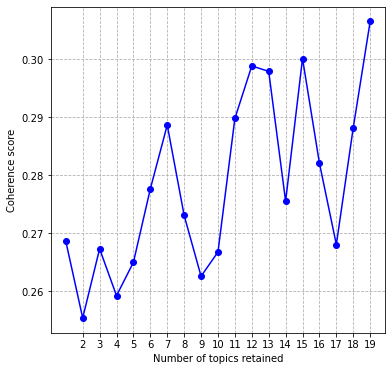

In [43]:
# Coherence scores plot
# data series
x = range(start, limit, step)
y = coher_vals

# create figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

# plot data
ax.plot(x,y, marker='o', color='b', ls='-')

# axes
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(np.arange(2, 20, 1))

# reference line
#ax.axvline(x=11, ymin=0, ymax=1, color='r')

# grid
ax.grid(True, ls='--')

# save plot to file
folder = 'exhibits'
file = 'post_1.pdf'
plt.savefig(os.path.join(folder,file),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)

plt.show()

In [44]:
# another apporach to evaluate model
# Compute Perplexity
print('\nPerplexity: ', lda_model_pre.log_perplexity(corpus_pre))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_post, texts=docs_phrased_post, dictionary=dict_post, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.366011365630671

Coherence Score:  0.49893618621537855


In [45]:
# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dict_post, corpus=corpus_post, texts=docs_phrased_post, start=2, limit=40, step=6)

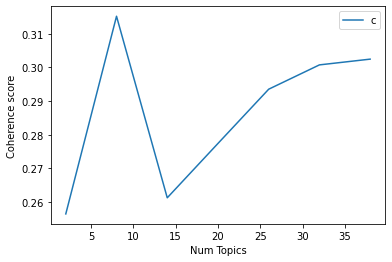

In [46]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# save plot to file
folder = 'exhibits'
file = 'post_2.pdf'
plt.savefig(os.path.join(folder,file),
            transparent=True,
            bbox_inches='tight',
            pad_inches=0)
plt.show()

In [47]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2565
Num Topics = 8  has Coherence Value of 0.3152
Num Topics = 14  has Coherence Value of 0.2613
Num Topics = 20  has Coherence Value of 0.2774
Num Topics = 26  has Coherence Value of 0.2935
Num Topics = 32  has Coherence Value of 0.3008
Num Topics = 38  has Coherence Value of 0.3025


In [48]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

def format_topics_sentences(ldamodel=lda_model_post, corpus=corpus_post, texts=docs_post):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus_post]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_post, texts=docs_post)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

[(0, '0.012*"service" + 0.008*"professor" + 0.005*"eu" + 0.005*"uk" + 0.005*"bn" + 0.005*"xc" + 0.005*"fund" + 0.004*"people" + 0.004*"work" + 0.003*"community"'), (1, '0.011*"service" + 0.005*"company" + 0.005*"business" + 0.004*"uk" + 0.004*"community" + 0.004*"world" + 0.004*"cent" + 0.004*"xc" + 0.004*"people" + 0.004*"new"'), (2, '0.019*"service" + 0.005*"community" + 0.005*"people" + 0.004*"work" + 0.004*"business" + 0.004*"energy" + 0.003*"need" + 0.003*"new" + 0.003*"city" + 0.003*"education"'), (3, '0.005*"uk" + 0.005*"people" + 0.005*"business" + 0.005*"service" + 0.004*"year" + 0.004*"company" + 0.004*"work" + 0.004*"eu" + 0.003*"cent" + 0.003*"government"'), (4, '0.005*"uk" + 0.005*"xc" + 0.005*"eu" + 0.004*"people" + 0.004*"right" + 0.004*"country" + 0.004*"development" + 0.004*"city" + 0.003*"new" + 0.003*"need"'), (5, '0.005*"fund" + 0.004*"imf" + 0.004*"market" + 0.004*"greece" + 0.003*"debt" + 0.003*"service" + 0.003*"need" + 0.003*"food" + 0.003*"company" + 0.003*"xc"

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.9930,"service, community, business, new, people, mar...",almost trillion in food is thrown away lost or...
1,1,12.0,0.9975,"service, community, business, new, people, mar...",it 's hard to get a clear picture of the emplo...
2,2,9.0,0.5774,"service, people, work, world, xc, reef, commun...",alive and kicking is an award winning uk chari...
3,3,12.0,0.4786,"service, community, business, new, people, mar...",elon musk faces a battle with shareholders ove...
4,4,12.0,0.5122,"service, community, business, new, people, mar...",michael sharp who is stepping down as chief ex...
5,5,12.0,0.9952,"service, community, business, new, people, mar...",dropbox once one of silicon valley 's fastest ...
6,6,16.0,0.7281,"service, professor, eu, uk, community, governm...",the mayor of london is pressing ahead with pla...
7,7,12.0,0.3820,"service, community, business, new, people, mar...",highlight there has been little enthusiasm for...
8,8,12.0,0.4152,"service, community, business, new, people, mar...",greece 's banking system yesterday took a big ...
9,9,12.0,0.7268,"service, community, business, new, people, mar...",there was something akin to desperation in the...


In [49]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4491,"service, professor, eu, uk, bn, xc, fund, peop...",which country does martin kettle may will have...
1,1.0,0.4183,"service, company, business, uk, community, wor...",highlight analysts remain cautious on gold 's ...
2,3.0,0.4153,"uk, people, business, service, year, company, ...",italian luxury leather goods group tod 's is w...
3,4.0,0.2116,"uk, xc, eu, people, right, country, developmen...",highlight landowners reject accusations of ill...
4,5.0,0.3293,"fund, imf, market, greece, debt, service, need...",when the mayor of madrid ana botella inaugurat...


In [50]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,12.0,"service, community, business, new, people, mar...",7.0,0.0326
1.0,12.0,"service, community, business, new, people, mar...",1.0,0.0047
2.0,9.0,"service, people, work, world, xc, reef, commun...",NaN,NaN
3.0,12.0,"service, community, business, new, people, mar...",3.0,0.0140
4.0,12.0,"service, community, business, new, people, mar...",1.0,0.0047
...,...,...,...,...
210.0,12.0,"service, community, business, new, people, mar...",NaN,NaN
211.0,12.0,"service, community, business, new, people, mar...",NaN,NaN
212.0,12.0,"service, community, business, new, people, mar...",NaN,NaN
213.0,12.0,"service, community, business, new, people, mar...",NaN,NaN


In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_1 = pyLDAvis.gensim.prepare(lda_model_post, corpus_post, dict_post)
vis_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.241060  0.010765       1        1  25.339149
5      0.215101  0.095989       2        1  19.065819
12     0.230290 -0.003742       3        1  11.362197
17     0.073820 -0.249422       4        1   9.782691
3      0.223810  0.083476       5        1   8.345175
16     0.171682 -0.138710       6        1   7.999641
19     0.070446 -0.115562       7        1   4.554646
8     -0.073248 -0.096711       8        1   3.590887
13     0.179264  0.142412       9        1   2.945604
1     -0.049261 -0.061942      10        1   2.389646
15     0.040242  0.127240      11        1   1.353468
4     -0.142546  0.037345      12        1   1.269543
0     -0.128899 -0.027441      13        1   1.192398
14    -0.161922  0.033281      14        1   0.344112
7     -0.147058  0.025490      15        1   0.189596
2     -0.161207  0.035295      16        1   0.183169
10    -0.147299  0.026232      17        1   0.041057
9     -0.145940  0.026003      18        1   0.029650
18    -0.144837  0.025383      19        1   0.018427
11    -0.143498  0.024617      20        1   0.003128, topic_info=                Term        Freq       Total Category  logprob  loglift
530           energy  472.000000  472.000000  Default  30.0000  30.0000
121          company  518.000000  518.000000  Default  29.0000  29.0000
61            people  209.000000  209.000000  Default  28.0000  28.0000
451            sport  261.000000  261.000000  Default  27.0000  27.0000
710               xc  326.000000  326.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
2230         morning    0.000311   78.120880  Topic20  -9.2245  -2.0619
549            month    0.000311  274.137939  Topic20  -9.2245  -3.3173
225           report    0.000311  186.732971  Topic20  -9.2245  -2.9334
1243  george_osborne    0.000311   61.857307  Topic20  -9.2245  -1.8286
39              high    0.000311  319.744110  Topic20  -9.2245  -3.4712

[1212 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3035     13  0.949346       ac
1004      5  0.971081   accept
0         1  0.385400   accord
0         2  0.085645   accord
0         3  0.428223   accord
...     ...       ...      ...
1096      9  0.253551    yield
5954     13  0.630597  youtube
5954     16  0.315299  youtube
490      10  0.890415   zambia
2913      7  0.929313     zone

[2062 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 13, 18, 4, 17, 20, 9, 14, 2, 16, 5, 1, 15, 8, 3, 11, 10, 19, 12])

In [52]:
# save pyLDAvis data to html file
pyLDAvis.save_html(vis_1, 'exhibits/topic_modelling_post_vis.html')

In [53]:
# Finding term to term probabilities
# get top 5 terms per topic
top_terms_line = lda_model_pre.show_topics(num_topics=n_topics, num_words=5)

In [54]:
# rearrange data on top 10 terms per topic
top_terms_m = []

for i in top_terms_line:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        top_terms_m.append([topic_num, term_sort, weight, term])

df_1 = pd.DataFrame(top_terms_m)

# rename columns
old_names = [0, 1, 2, 3]
new_names = ['topic_n', 'term_sort', 'weight', 'term']
cols = dict(zip(old_names, new_names))
df_1.rename(columns=cols, inplace=True)
df_1.set_index(['term_sort', 'topic_n'], inplace=True)
df_1 = df_1.unstack()

# sidewaystable
df_h = pd.DataFrame()

for i in range(10):
    terms = df_1['term'][i]
    weights = df_1['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights ])
    df_h = pd.concat([df_h, terms, weights], axis=1)

# write data to file
folder = 'exhibits'
file3 = 'post.html'
df_h.T.to_html(os.path.join(folder, file3), index=True)